In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
#Imagem será convertida em um tensor
transform =  transforms.ToTensor()

# Dataset de treino
trainSet = datasets.MNIST('./MNIST_data/', download=True, train=True,transform=transform)
#Buffer de dados de treino
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=(64), shuffle=True)

valSet = datasets.MNIST('./MNIST_data/', download=True, train=False,transform=transform)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=(64), shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 35841315.77it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21523755.12it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42066954.15it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3453685.42it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [13]:
type(trainSet)

torchvision.datasets.mnist.MNIST

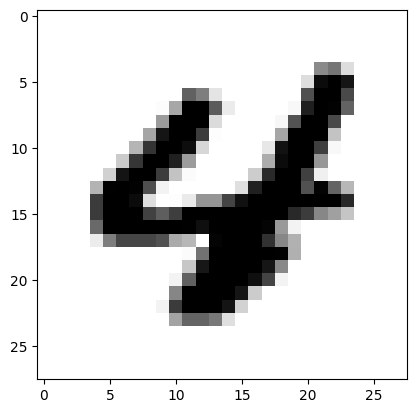

Shape da imagem: torch.Size([1, 28, 28])


In [6]:
# Iterar sobre o DataLoader usando um loop for
for img, label in trainLoader:
    plt.imshow(img[0].numpy().squeeze(), cmap='gray_r')
    plt.show()
    print("Shape da imagem:", img[0].shape)
    break

In [7]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(28*28,128)
    self.linear2 = nn.Linear(128,64)
    self.linear3 = nn.Linear(64,10)

  def forward(self,X):
    X = F.relu(self.linear1(X))
    X = F.relu(self.linear2(X))
    X = self.linear3(X)
    return F.log_softmax(X, dim=1)

In [8]:
def train(model, trainLoader, device):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  init = time()

  criterion = nn.NLLLoss()
  epochs = 10
  model.train()

  for epoch in range(epochs):
    acm_loss = 0

    for imgs, labels in trainLoader:
      imgs = imgs.view(imgs.shape[0], -1)
      optimizer.zero_grad()

      output = model(imgs.to(device))
      instant_loss = criterion(output, labels.to(device))
      instant_loss.backward()

      optimizer.step()

      acm_loss += instant_loss.item()

    else:
      print("Epoch {} - Resultant Loss {}".format(epoch+1, acm_loss/len(trainLoader)))

  print("\n Training time (in minutes):", (time()-init)/60)

In [9]:
def validate(modelo, valLoader, device):
  right_answer, all_answer = 0,0

  for imgs, labels in valLoader:
    for i in range(len(labels)):
      img = imgs[i].view(1,784)
      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      prob = list(ps.cpu().numpy()[0])
      label_pred = prob.index(max(prob))
      right_label = labels.numpy()[i]

      if(right_label == label_pred):
        right_answer += 1

      all_answer += 1

  print("All tested images:", all_answer)
  print("Model accuracy: {}%".format(right_answer*100/all_answer))


In [10]:
model = Model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
train(model, trainLoader, device)

Epoch 1 - Resultant Loss 1.1993162666937944
Epoch 2 - Resultant Loss 0.38203479663363654
Epoch 3 - Resultant Loss 0.31118188583170936
Epoch 4 - Resultant Loss 0.2708826340965307
Epoch 5 - Resultant Loss 0.23966927369282062
Epoch 6 - Resultant Loss 0.21315900027465973
Epoch 7 - Resultant Loss 0.19143633254523726
Epoch 8 - Resultant Loss 0.1726333050132751
Epoch 9 - Resultant Loss 0.15733553277753565
Epoch 10 - Resultant Loss 0.14421678843822625

 Training time (in minutes): 1.612431287765503


In [12]:
validate(model, valLoader, device)

All tested images: 10000
Model accuracy: 95.9%
